In [1]:
from tensorflow.keras.datasets import mnist
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import importlib
import helper
importlib.reload(helper)

sns.set_theme()
(x_train, y_labels) , (x_test, y_test) = mnist.load_data()
train_morpho = pd.read_csv("./Data/train-morpho.csv")
test_morpho = pd.read_csv("./Data/t10k-morpho.csv")
train_morpho.drop(["index"], axis=1, inplace=True)
test_morpho.drop(["index"], axis=1, inplace=True)

train_morpho.slant = train_morpho.slant*180/np.pi
test_morpho.slant = test_morpho.slant*180/np.pi

x_test = x_test/255
x_val = x_train[50000:]/255
y_val = train_morpho.slant.to_numpy()[50000:] 
x_train = x_train[:50000]/255
y_train = train_morpho.slant.to_numpy()[:50000]
x_emb = y_labels[:50000]
x_emb_val = y_labels[50000:]
labels = np.unique(y_labels)

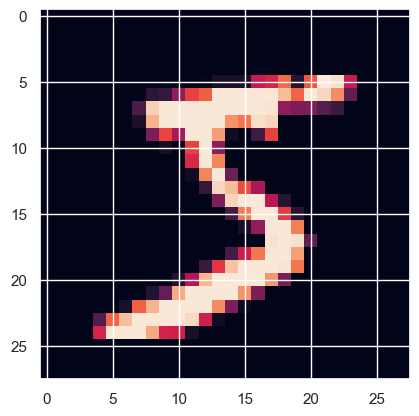

In [16]:
plt.imshow(x_train[0])

Text(0.5, 1.0, 'Data Distribution')

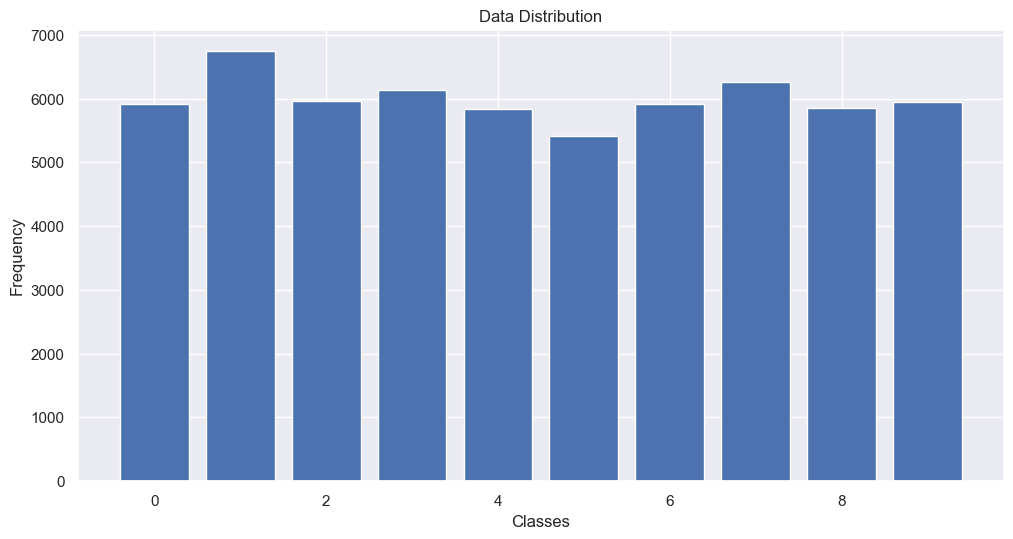

In [8]:
num, frequency = np.unique(y_labels, return_counts=True)
plt.bar(labels, frequency)
plt.gcf().tight_layout(pad=0)
plt.gcf().set_figwidth(10)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Data Distribution")

<AxesSubplot:>

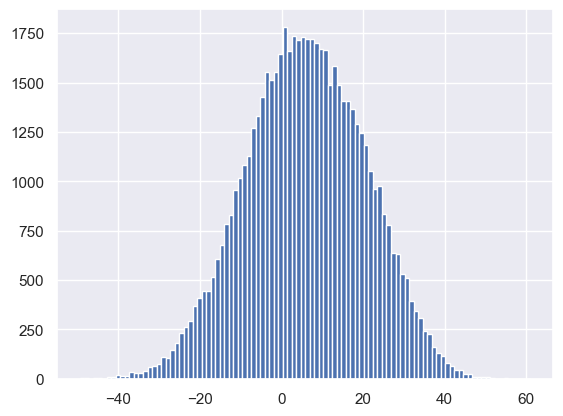

In [18]:
train_morpho.slant.hist(bins=100)

In [9]:
train_morpho.iloc[y_labels==1]

,area,length,thickness,slant,width,height
3,67.3125,22.849242,2.919769,29.174163,5.358179,19.724599
6,69.3750,19.838835,3.457017,-8.889683,5.026869,19.711565
8,41.8125,20.363961,2.190367,-4.378080,3.772309,19.458175
14,44.1250,21.692388,2.216605,-3.072578,3.974149,19.538955
23,64.6875,22.245689,2.854460,30.190546,5.230590,19.475603
...,...,...,...,...,...,...
59958,47.7500,22.977922,2.160946,23.981700,4.160436,19.564109
59965,63.9375,24.341883,2.577189,37.785202,5.596039,19.560789
59979,48.6250,23.952796,2.155981,28.702996,4.343587,19.500440
59984,59.5625,25.609650,2.378904,37.924730,5.011157,19.546802


# $\textit{Slant vs Morphos}$

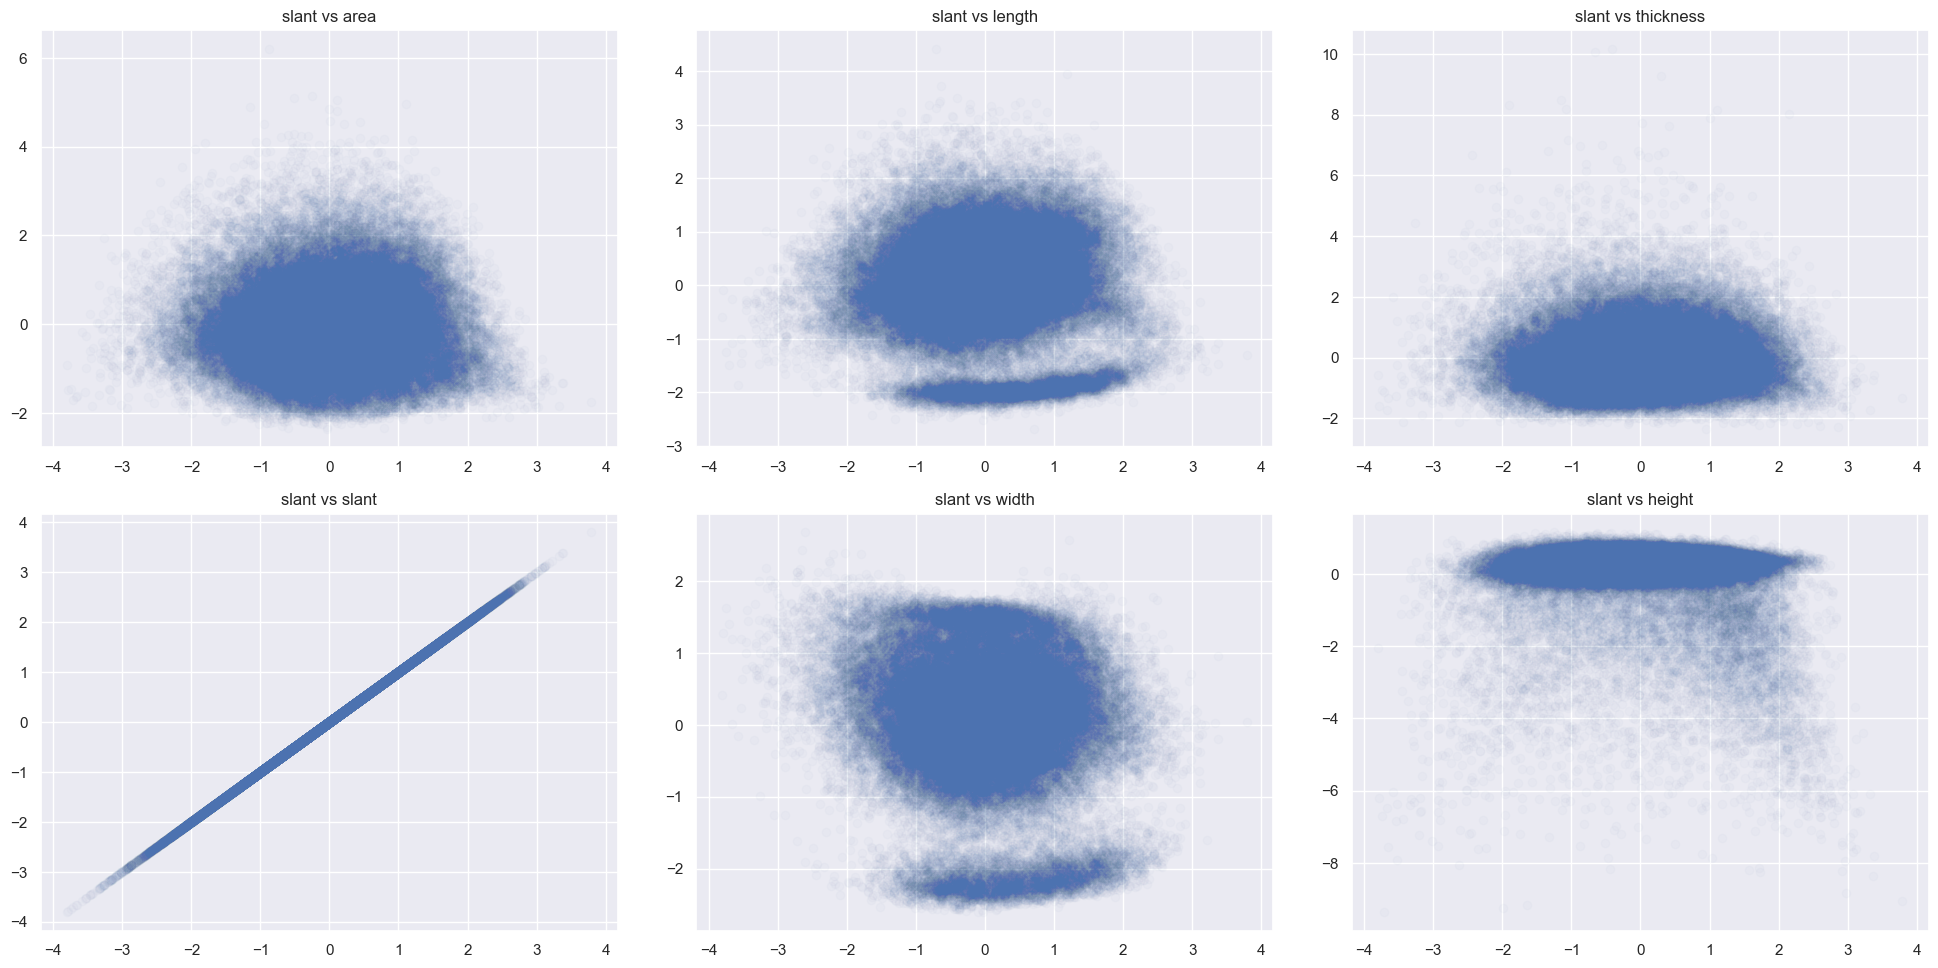

In [3]:
fig, axs = plt.subplots(2,3,figsize=(20,10))
fig.tight_layout(pad=2)

normMorpho = (train_morpho-train_morpho.mean())/train_morpho.std()

for i in range(2):
    for j in range(3):
        morph = train_morpho.columns[3*i+j]
        axs[i][j].set_title(f"slant vs {morph}")
        axs[i][j].scatter(normMorpho.slant, normMorpho[morph], alpha=0.02)

$\textit{Se observa correlacion entre slant vs length}$

In [10]:
norm = ((train_morpho.length-train_morpho.length.mean())/train_morpho.length.std())
var_x_train = norm.to_numpy()[:50000]
var_x_val = norm.to_numpy()[50000:]
norm = ((test_morpho.length-test_morpho.length.mean())/test_morpho.length.std())
var_x_test = norm.to_numpy()

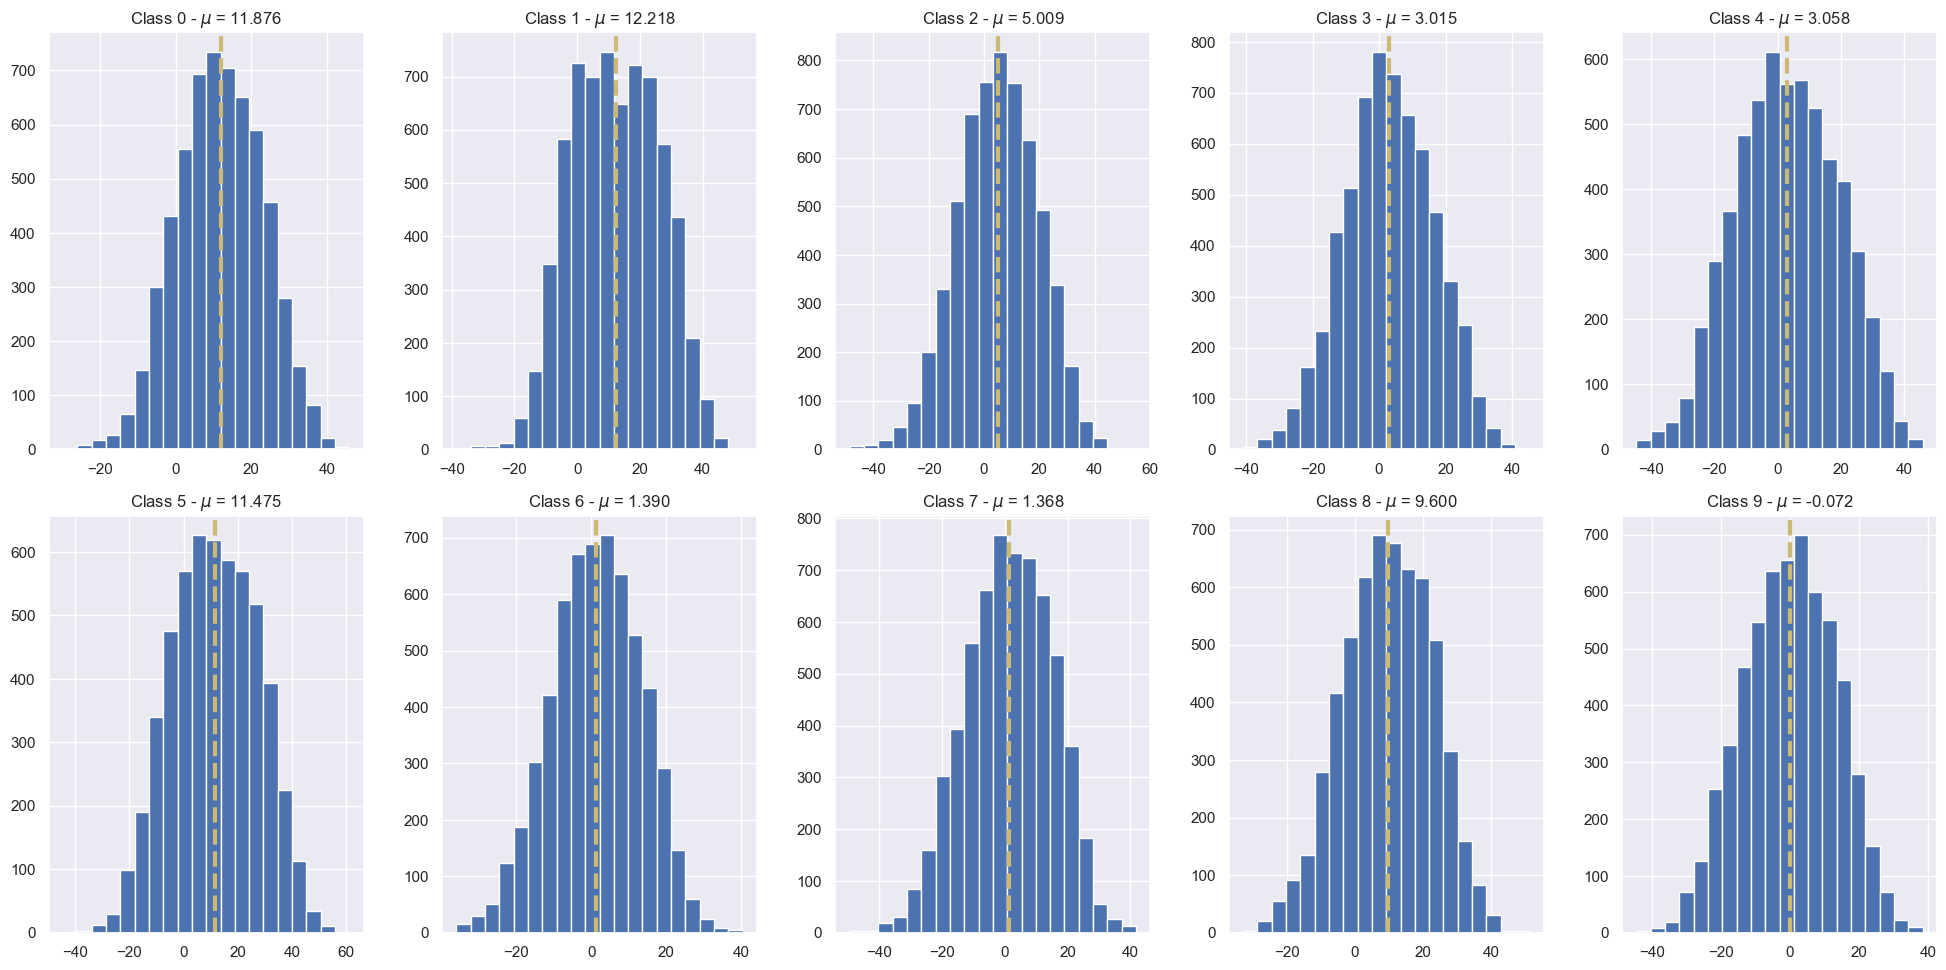

In [11]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
fig.tight_layout(pad=2)

for i in range(2):
    for j in range(5):
        mu = train_morpho.iloc[y_labels==i*5+j].slant.mean()
        axs[i][j].set_title(f"Class {i*5+j} - $\mu$ = {mu:.3f}")
        axs[i][j].hist(train_morpho.iloc[y_labels==i*5+j].slant, bins=20)
        axs[i][j].axvline(mu, color='y', linestyle='dashed', linewidth=3)

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.losses import MeanAbsoluteError
import tensorflow_addons as tfa
import tensorflow as tf
import importlib as imp
import helper
imp.reload(helper)

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


<module 'helper' from 'c:\\Users\\Gonzalo\\Documents\\Informatica\\EclipseWorkspacePython\\TP1_RN\\MorphometricMNIST\\helper.py'>

## $\textit{Predict using image only}$

In [23]:
BATCH_SIZE = 64
INIT_LR = 0.000005
MAX_LR = 0.001
steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

loc = './Model/MorphometricMNISTBase/training_history.log'
callbackH = helper.callbackH(location=loc)

callbackROP = ReduceLROnPlateau(monitor="val_mae",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 10,
                      max_lr = MAX_LR)

callbackES = EarlyStopping(monitor="val_mae", patience=20)
initializer = GlorotNormal(1)
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))
model.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))
model.add(Dense(1, activation="linear", kernel_initializer=initializer))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_21 (Dense)            (None, 100)               78500     
                                                                 
 dense_22 (Dense)            (None, 100)               10100     
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 88,701
Trainable params: 88,701
Non-trainable params: 0
_________________________________________________________________


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [24]:
model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
history = model.fit(x=x_train, y =y_train, validation_data=(x_val, y_val), callbacks=[callbackES, callbackROP, callbackH], batch_size = BATCH_SIZE, epochs=200)
model.save("./Model/MorphometricMNISTBase")

Epoch 1/200
782/782 [==============================] - 3s 3ms/step - loss: 9.1237 - mae: 9.1237 - val_loss: 3.5370 - val_mae: 3.5370 - lr: 5.0250e-04
Epoch 2/200
782/782 [==============================] - 2s 3ms/step - loss: 1.7021 - mae: 1.7021 - val_loss: 0.7941 - val_mae: 0.7941 - lr: 9.9936e-04
Epoch 3/200
782/782 [==============================] - 2s 2ms/step - loss: 0.4751 - mae: 0.4751 - val_loss: 0.3135 - val_mae: 0.3135 - lr: 5.0123e-04
Epoch 4/200
782/782 [==============================] - 2s 2ms/step - loss: 0.3170 - mae: 0.3170 - val_loss: 0.2622 - val_mae: 0.2622 - lr: 5.9555e-06
Epoch 5/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2877 - mae: 0.2877 - val_loss: 0.2643 - val_mae: 0.2643 - lr: 2.5502e-04
Epoch 6/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2639 - mae: 0.2639 - val_loss: 0.2325 - val_mae: 0.2325 - lr: 5.0091e-04
Epoch 7/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2282 - mae: 0.2282 - va

INFO:tensorflow:Assets written to: ./Model/MorphometricMNISTBase\assets


INFO:tensorflow:Assets written to: ./Model/MorphometricMNISTBase\assets


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


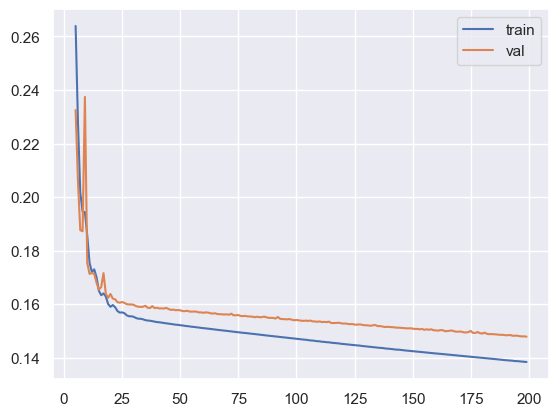

In [25]:
mode = load_model("./Model/MorphometricMNISTBase", compile=False)
histo = pd.read_csv("./Model/MorphometricMNISTBase/training_history.log")
plt.plot(histo["mae"][5:], label="train")
plt.plot(histo["val_mae"][5:], label="val")
plt.legend()
plt.show()

In [36]:
from sklearn.metrics import mean_absolute_error
model = load_model("./Model/MorphometricMNISTBase", compile=False)
predicted = model.predict(x_test).reshape(10000,)
df = pd.DataFrame()
df["pred"] = predicted
df["target"] = test_morpho.slant
m = (np.abs(df.pred-df.target)).sum()/len(df.pred)
print(f"MAE_TEST: {m}")
df

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


313/313 [==============================] - 1s 2ms/step
MAE_TEST: 0.1457327933951882


,pred,target
0,3.990440,4.066199
1,-10.086285,-9.962917
2,16.531540,16.638250
3,4.167469,4.146705
4,-7.648934,-7.378214
...,...,...
9995,-1.437816,-1.446727
9996,-4.258973,-4.309251
9997,11.348402,11.246739
9998,29.885872,30.389567


## $\textit{Predict using image and label}$

In [3]:
from keras.layers import Embedding, Concatenate, Input
from keras import Model

In [53]:
BATCH_SIZE = 64
INIT_LR = 0.000005
MAX_LR = 0.001
steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

loc = './Model/MorphometricMNISTEmbedding1/training_history.log'
callbackH = helper.callbackH(location=loc)

callbackROP = ReduceLROnPlateau(monitor="val_mae",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 10,
                      max_lr = MAX_LR)

callbackES = EarlyStopping(monitor="val_mae", patience=20)
initializer = GlorotNormal()

entImg = Input(shape=(28,28))

lbl = Input(shape=(1,))
emb = Embedding(len(labels), 2, input_length=1, name="Embe")(lbl)

faltEmb = Flatten()(emb)
flatImg = Flatten()(entImg)

concat = Concatenate()([flatImg, faltEmb])

model = Sequential()
model.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))
model.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))
model.add(Dense(1, activation="linear", kernel_initializer=initializer))
net = model(concat)
model = Model(inputs=[entImg, lbl], outputs=net)
model.summary()
model.save_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 Embe (Embedding)               (None, 1, 2)         20          ['input_11[0][0]']               
                                                                                                  
 flatten_14 (Flatten)           (None, 784)          0           ['input_10[0][0]']               
                                                                                            

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [17]:
model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
history = model.fit(x=[x_train, x_emb], y =y_train, validation_data=([x_val, x_emb_val], y_val), callbacks=[callbackES, callbackROP, callbackH], batch_size = BATCH_SIZE, epochs=200)
model.save("./Model/MorphometricMNISTEmbedding1")

Epoch 1/200
782/782 [==============================] - 4s 3ms/step - loss: 8.2881 - mae: 8.2881 - val_loss: 2.7247 - val_mae: 2.7247 - lr: 5.0250e-04
Epoch 2/200
782/782 [==============================] - 2s 3ms/step - loss: 1.3811 - mae: 1.3811 - val_loss: 0.7374 - val_mae: 0.7374 - lr: 9.9936e-04
Epoch 3/200
782/782 [==============================] - 2s 3ms/step - loss: 0.4436 - mae: 0.4436 - val_loss: 0.3055 - val_mae: 0.3055 - lr: 5.0123e-04
Epoch 4/200
782/782 [==============================] - 2s 3ms/step - loss: 0.3081 - mae: 0.3081 - val_loss: 0.2571 - val_mae: 0.2571 - lr: 5.9555e-06
Epoch 5/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2820 - mae: 0.2820 - val_loss: 0.2467 - val_mae: 0.2467 - lr: 2.5502e-04
Epoch 6/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2629 - mae: 0.2629 - val_loss: 0.2593 - val_mae: 0.2593 - lr: 5.0091e-04
Epoch 7/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2302 - mae: 0.2302 - va

INFO:tensorflow:Assets written to: ./Model/MorphometricMNISTEmbedding1\assets


INFO:tensorflow:Assets written to: ./Model/MorphometricMNISTEmbedding1\assets


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


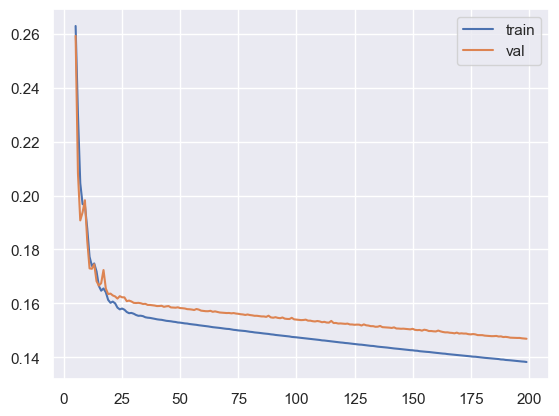

In [23]:
mode = load_model("./Model/MorphometricMNISTEmbedding1", compile=False)
histo = pd.read_csv("./Model/MorphometricMNISTEmbedding1/training_history.log")
plt.plot(histo["mae"][5:], label="train")
plt.plot(histo["val_mae"][5:], label="val")
plt.legend()
plt.show()

In [37]:
model = load_model("./Model/MorphometricMNISTEmbedding1", compile=False)
predicted = model.predict([x_test, y_test]).reshape(10000,)
df = pd.DataFrame()
df["pred"] = predicted
df["target"] = test_morpho.slant
m = (np.abs(df.pred-df.target)).sum()/len(df.pred)
print(f"MAE_TEST: {m}")
df

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


313/313 [==============================] - 1s 2ms/step
MAE_TEST: 0.14609865700606198


,pred,target
0,4.000932,4.066199
1,-10.095608,-9.962917
2,16.541965,16.638250
3,4.189748,4.146705
4,-7.610396,-7.378214
...,...,...
9995,-1.354924,-1.446727
9996,-4.271663,-4.309251
9997,11.317192,11.246739
9998,29.858393,30.389567


$\textit{Embedding Plot}$

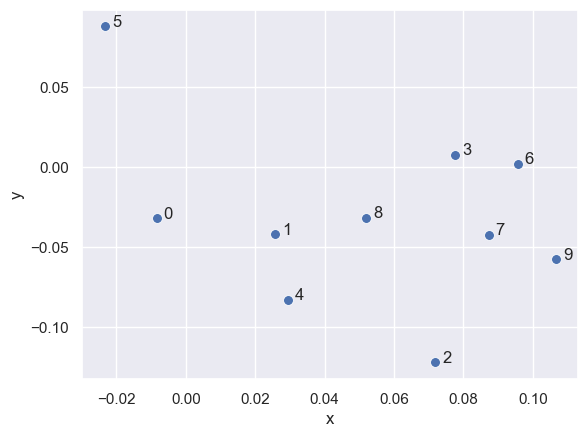

In [20]:
from matplotlib import cm

layerName = 'Embe'
intermediate_layer = Model(inputs=model.get_layer(layerName).input,
                                    outputs=model.get_layer(layerName).output)


intermediate_output = intermediate_layer(labels)


x = intermediate_output[:, 0, 0]
y = intermediate_output[:, 0, 1]

data = pd.DataFrame()
data["x"] = x
data["y"] = y
data["label"] = labels

sns.scatterplot(
    x="x", y="y",
    s = 50,
    data=data,
)

for i in labels:
    plt.text(data['x'][i]+.002, data['y'][i], str(i))

Se entiende que la capa de embedding trata de buscar relaciones entre los datos de entrada. Se observa que los numeros 0 y 5 se encuentran alejados de los otros grupos de numeros, esto puede corresponderse a que estos ultimos son aquellos que mayor media tienen. Ademas, se observa que el grupo 3, 6, 7 y 9 tienen un valor de media similares, decreciendo sobre el eje y. 

## $\textit{Predict using image and height}$

In [24]:
BATCH_SIZE = 64
INIT_LR = 0.000005
MAX_LR = 0.001
steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

loc = './Model/MorphometricMNIST_H/training_history.log'
callbackH = helper.callbackH(location=loc)

callbackROP = ReduceLROnPlateau(monitor="val_mae",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 10,
                      max_lr = MAX_LR)

callbackES = EarlyStopping(monitor="val_mae", patience=20)
initializer = GlorotNormal(1)

measure = Sequential()
measure.add(Input((1,)))

img = Sequential()
img.add(Flatten(input_shape=(28,28)))
img.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))
img.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))

modelConcat = Concatenate()([img.output, measure.output])
modelConcat = Dense(1, activation="linear", kernel_initializer=initializer)(modelConcat)
model = Model(inputs=[img.input, measure.input], outputs=modelConcat)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 flatten_6_input (InputLayer)   [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_6 (Flatten)            (None, 784)          0           ['flatten_6_input[0][0]']        
                                                                                                  
 dense_6 (Dense)                (None, 100)          78500       ['flatten_6[0][0]']              
                                                                                                  
 dense_7 (Dense)                (None, 100)          10100       ['dense_6[0][0]']                
                                                                                            

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [25]:
model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
history = model.fit(x=[x_train, var_x_train], y =y_train, validation_data=([x_val, var_x_val], y_val), callbacks=[callbackES, callbackROP, callbackH], batch_size = BATCH_SIZE, epochs=200)
model.save("./Model/MorphometricMNIST_H")

Epoch 1/200
782/782 [==============================] - 4s 3ms/step - loss: 8.6557 - mae: 8.6557 - val_loss: 2.9613 - val_mae: 2.9613 - lr: 5.0250e-04
Epoch 2/200
782/782 [==============================] - 2s 3ms/step - loss: 1.4213 - mae: 1.4213 - val_loss: 0.5244 - val_mae: 0.5244 - lr: 9.9936e-04
Epoch 3/200
782/782 [==============================] - 2s 3ms/step - loss: 0.4376 - mae: 0.4376 - val_loss: 0.2988 - val_mae: 0.2988 - lr: 5.0123e-04
Epoch 4/200
782/782 [==============================] - 2s 3ms/step - loss: 0.3028 - mae: 0.3028 - val_loss: 0.2549 - val_mae: 0.2549 - lr: 5.9555e-06
Epoch 5/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2786 - mae: 0.2786 - val_loss: 0.2455 - val_mae: 0.2455 - lr: 2.5502e-04
Epoch 6/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2613 - mae: 0.2613 - val_loss: 0.2349 - val_mae: 0.2349 - lr: 5.0091e-04
Epoch 7/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2302 - mae: 0.2302 - va

INFO:tensorflow:Assets written to: ./Model/MorphometricMNIST_H\assets


INFO:tensorflow:Assets written to: ./Model/MorphometricMNIST_H\assets


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


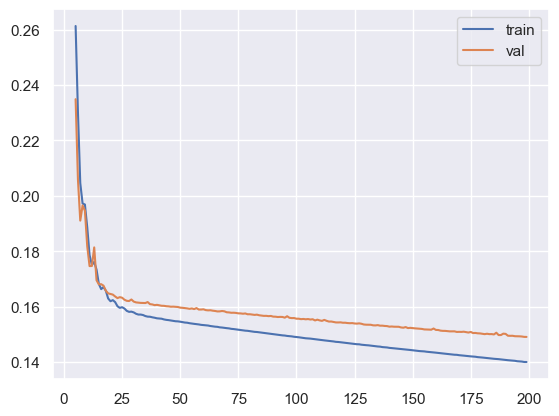

In [28]:
mode = load_model("./Model/MorphometricMNIST_H", compile=False)
histo = pd.read_csv("./Model/MorphometricMNIST_H/training_history.log")
plt.plot(histo["mae"][5:], label="train")
plt.plot(histo["val_mae"][5:], label="val")
plt.legend()
plt.show()

In [38]:
model = load_model("./Model/MorphometricMNIST_H", compile=False)
predicted = model.predict([x_test, var_x_test]).reshape(10000,)
df = pd.DataFrame()
df["pred"] = predicted
df["target"] = test_morpho.slant
m = (np.abs(df.pred-df.target)).sum()/len(df.pred)
print(f"MAE_TEST: {m}")
df

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


313/313 [==============================] - 1s 2ms/step
MAE_TEST: 0.14688759566209125


,pred,target
0,3.957623,4.066199
1,-10.080206,-9.962917
2,16.545143,16.638250
3,4.164035,4.146705
4,-7.679639,-7.378214
...,...,...
9995,-1.406305,-1.446727
9996,-4.308898,-4.309251
9997,11.292850,11.246739
9998,29.952961,30.389567


$\textit{MAE vs BATCHSIZE}$

In [79]:
model = load_model("./Model/MorphometricMNISTEmbedding1", compile=False)
model.load_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")
INIT_LR = 0.000005
MAX_LR = 0.001
BATCH_SIZE = 32
mae_valResults = []

steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

for i in range(6):
    model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
    history = model.fit(x=[x_train, x_emb], y =y_train, validation_data=([x_val, x_emb_val], y_val), callbacks=[callbackES, callbackROP], batch_size = BATCH_SIZE, epochs=200)
    mae_valResults.append(history.history["val_mae"][-1])
    print(history.history["val_mae"][-1])
    model.load_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")
    BATCH_SIZE = int(BATCH_SIZE * 2)

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/200


1563/1563 [==============================] - 7s 4ms/step - loss: 7.5010 - mae: 7.5010 - val_loss: 1.8482 - val_mae: 1.8482 - lr: 5.0250e-04
Epoch 2/200
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8848 - mae: 0.8848 - val_loss: 0.3696 - val_mae: 0.3696 - lr: 9.9968e-04
Epoch 3/200
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3199 - mae: 0.3199 - val_loss: 0.2589 - val_mae: 0.2589 - lr: 5.0186e-04
Epoch 4/200
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2262 - mae: 0.2262 - val_loss: 0.1946 - val_mae: 0.1946 - lr: 5.4778e-06
Epoch 5/200
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2055 - mae: 0.2055 - val_loss: 0.2018 - val_mae: 0.2018 - lr: 2.5439e-04
Epoch 6/200
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2062 - mae: 0.2062 - val_loss: 0.2027 - val_mae: 0.2027 - lr: 5.0170e-04
Epoch 7/200
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1903 - mae: 0.1903 - 

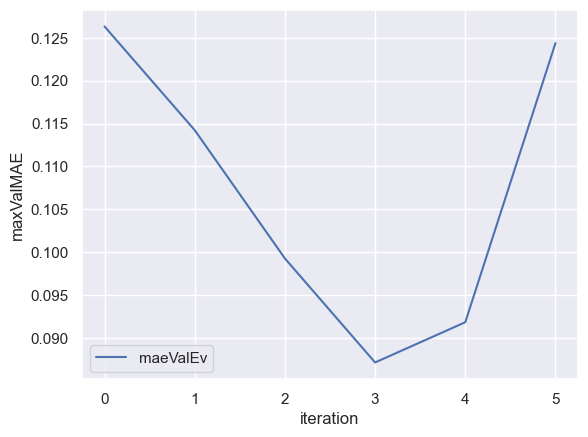

In [81]:
plt.plot(mae_valResults, label="maeValEv")
plt.xlabel("iteration")
plt.ylabel("maxValMAE")
plt.legend()
plt.show()

$\textit{MAE vs OPT}$

In [4]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Nadam, Adamax

In [64]:
INIT_LR = 0.0001
MAX_LR = 0.02
BATCH_SIZE = 256

steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)


callbackROP = ReduceLROnPlateau(monitor="val_mae",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 10,
                      max_lr = MAX_LR)

callbackES = EarlyStopping(monitor="val_mae", patience=20)
initializer = GlorotNormal(1)

entImg = Input(shape=(28,28))

lbl = Input(shape=(1,))
emb = Embedding(len(labels), 2, input_length=1, name="Embe")(lbl)

faltEmb = Flatten()(emb)
flatImg = Flatten()(entImg)

concat = Concatenate()([flatImg, faltEmb])

model = Sequential()
model.add(Dense(100, activation="elu", kernel_initializer=initializer))
model.add(Dense(100, activation="elu", kernel_initializer=initializer))
model.add(Dense(1, activation="linear", kernel_initializer=initializer))
net = model(concat)
model = Model(inputs=[entImg, lbl], outputs=net)
model.load_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")

opts = [SGD, RMSprop, Adam, Adagrad, Nadam, Adamax]

for opt in opts:
    model.compile(loss = MeanAbsoluteError(), optimizer=opt(), metrics=["mae"])
    history = model.fit(x=[x_train, x_emb], y =y_train, validation_data=([x_val, x_emb_val], y_val), callbacks=[callbackES, callbackROP], batch_size = BATCH_SIZE, epochs=200)
    mae_valResults.append(history.history["val_mae"][-1])
    model.load_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")

Epoch 1/200
196/196 [==============================] - 1s 4ms/step - loss: 5.3615 - mae: 5.3615 - val_loss: 2.9320 - val_mae: 2.9320 - lr: 0.0100
Epoch 2/200
196/196 [==============================] - 1s 4ms/step - loss: 2.9546 - mae: 2.9546 - val_loss: 2.7090 - val_mae: 2.7090 - lr: 0.0100
Epoch 3/200
196/196 [==============================] - 1s 4ms/step - loss: 2.2063 - mae: 2.2063 - val_loss: 2.0643 - val_mae: 2.0643 - lr: 0.0100
Epoch 4/200
196/196 [==============================] - 1s 4ms/step - loss: 1.8346 - mae: 1.8346 - val_loss: 1.4936 - val_mae: 1.4936 - lr: 0.0100
Epoch 5/200
196/196 [==============================] - 1s 3ms/step - loss: 1.6120 - mae: 1.6120 - val_loss: 1.5475 - val_mae: 1.5475 - lr: 0.0100
Epoch 6/200
196/196 [==============================] - 1s 3ms/step - loss: 1.4605 - mae: 1.4605 - val_loss: 1.5207 - val_mae: 1.5207 - lr: 0.0100
Epoch 7/200
196/196 [==============================] - 1s 3ms/step - loss: 1.3412 - mae: 1.3412 - val_loss: 1.2072 - val_mae

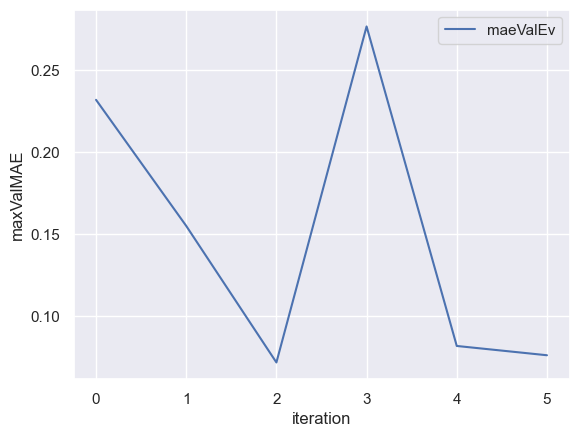

In [65]:
plt.plot(mae_valResults, label="maeValEv")
plt.xlabel("iteration")
plt.ylabel("maxValMAE")
plt.legend()
plt.show()

$\textit{MAE vs LR}$

In [44]:
INIT_LR = 0.0001
MAX_LR = 0.1
BATCH_SIZE = 256
currLR = INIT_LR
currMLR = MAX_LR
mae_valResults = []

steps_per_epoch = len(x_train) // BATCH_SIZE

callbackES = EarlyStopping(monitor="val_mae", patience=20)
initializer = GlorotNormal(1)

emb = Sequential()
emb.add(Embedding(len(labels), 2, input_length=1, name="Embe"))
emb.add(Flatten())

img = Sequential()
img.add(Flatten(input_shape=(28,28)))
img.add(Dense(100, activation="elu", kernel_initializer=initializer))
img.add(Dense(100, activation="elu", kernel_initializer=initializer))

modelConcat = Concatenate()([img.output, emb.output])
modelConcat = Dense(1, activation="linear", kernel_initializer=initializer)(modelConcat)
model = Model(inputs=[img.input, emb.input], outputs=modelConcat)
model.summary()
model.save_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")

for i in range(6):
    for j in range(6):
        callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=currLR,
                                                            maximal_learning_rate=currMLR,
                                                            scale_fn=lambda x: 1/(2.**(x-1)),
                                                            step_size=2 * steps_per_epoch
                                                        )

        callbackROP = ReduceLROnPlateau(monitor="val_mae",
                            factor = 0.1,
                            verbose= 1,
                            pacience = 10,
                            max_lr = currMLR)
        model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
        history = model.fit(x=[x_train, x_emb], y =y_train, validation_data=([x_val, x_emb_val], y_val), callbacks=[callbackES, callbackROP], batch_size = BATCH_SIZE, epochs=200)
        mae_valResults.append(history.history["val_mae"][-1])
        model.load_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")
        currLR = INIT_LR/5
    currLR = INIT_LR
    currMLR = currLR/5

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 flatten_12_input (InputLayer)  [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_12 (Flatten)           (None, 784)          0           ['flatten_12_input[0][0]']       
                                                                                                  
 Embe_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 100)          78500       ['flatten_12[0][0]']             
                                                                                            

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/200
196/196 [==============================] - 2s 5ms/step - loss: 2.7686 - mae: 2.7686 - val_loss: 1.2073 - val_mae: 1.2073 - lr: 0.0501
Epoch 2/200
196/196 [==============================] - 1s 4ms/step - loss: 2.1035 - mae: 2.1035 - val_loss: 2.8584 - val_mae: 2.8584 - lr: 0.0997
Epoch 3/200
196/196 [==============================] - 1s 4ms/step - loss: 1.6196 - mae: 1.6196 - val_loss: 1.0399 - val_mae: 1.0399 - lr: 0.0495
Epoch 4/200
196/196 [==============================] - 1s 4ms/step - loss: 0.6501 - mae: 0.6501 - val_loss: 0.4407 - val_mae: 0.4407 - lr: 4.8423e-04
Epoch 5/200
196/196 [==============================] - 1s 5ms/step - loss: 0.5113 - mae: 0.5113 - val_loss: 0.8147 - val_mae: 0.8147 - lr: 0.0256
Epoch 6/200
196/196 [==============================] - 1s 4ms/step - loss: 0.9773 - mae: 0.9773 - val_loss: 1.4692 - val_mae: 1.4692 - lr: 0.0494
Epoch 7/200
196/196 [==============================] - 1s 4ms/step - loss: 0.8819 - mae: 0.8819 - val_loss: 0.4839 - val

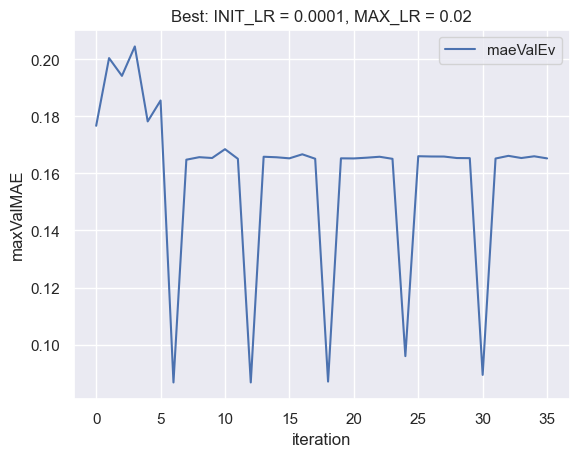

In [46]:
plt.plot(mae_valResults, label="maeValEv")
plt.xlabel("iteration")
plt.ylabel("maxValMAE")
plt.title(f"Best: INIT_LR = 0.0001, MAX_LR = 0.02")
plt.legend()
plt.show()

$\textit{MAE vs ACTIVATIONS}$

In [82]:
model = load_model("./Model/MorphometricMNISTEmbedding1", compile=False)
model.load_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")
INIT_LR = 0.000005
MAX_LR = 0.001
BATCH_SIZE = 256
mae_valResults = []
activs = ["exponential", "relu", "elu", "sigmoid", "tanh", "selu"]

steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

for act in activs:

    emb = Sequential()
    emb.add(Embedding(len(labels), 2, input_length=1, name="Embe"))
    emb.add(Flatten())

    img = Sequential()
    img.add(Flatten(input_shape=(28,28)))
    img.add(Dense(100, activation=act, kernel_initializer=initializer))
    img.add(Dense(100, activation=act, kernel_initializer=initializer))

    modelConcat = Concatenate()([img.output, emb.output])
    modelConcat = Dense(1, activation="linear", kernel_initializer=initializer)(modelConcat)
    model = Model(inputs=[img.input, emb.input], outputs=modelConcat)
    
    model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
    history = model.fit(x=[x_train, x_emb], y =y_train, validation_data=([x_val, x_emb_val], y_val), callbacks=[callbackES, callbackROP], batch_size = BATCH_SIZE, epochs=200)
    mae_valResults.append(history.history["val_mae"][-1])
    model.load_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/200


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


196/196 [==============================] - 2s 6ms/step - loss: 5.4281 - mae: 5.4281 - val_loss: 1.6520 - val_mae: 1.6520 - lr: 5.0250e-04
Epoch 2/200
196/196 [==============================] - 1s 6ms/step - loss: 1.3407 - mae: 1.3407 - val_loss: 0.8487 - val_mae: 0.8487 - lr: 9.9745e-04
Epoch 3/200
196/196 [==============================] - 1s 5ms/step - loss: 0.8250 - mae: 0.8250 - val_loss: 0.6185 - val_mae: 0.6185 - lr: 4.9740e-04
Epoch 4/200
196/196 [==============================] - 1s 5ms/step - loss: 0.5514 - mae: 0.5514 - val_loss: 0.5261 - val_mae: 0.5261 - lr: 8.8269e-06
Epoch 5/200
196/196 [==============================] - 1s 5ms/step - loss: 0.5023 - mae: 0.5023 - val_loss: 0.5208 - val_mae: 0.5208 - lr: 2.5885e-04
Epoch 6/200
196/196 [==============================] - 1s 6ms/step - loss: 0.5682 - mae: 0.5682 - val_loss: 0.9049 - val_mae: 0.9049 - lr: 4.9612e-04
Epoch 7/200
196/196 [==============================] - 1s 6ms/step - loss: 0.4729 - mae: 0.4729 - val_loss: 0.42

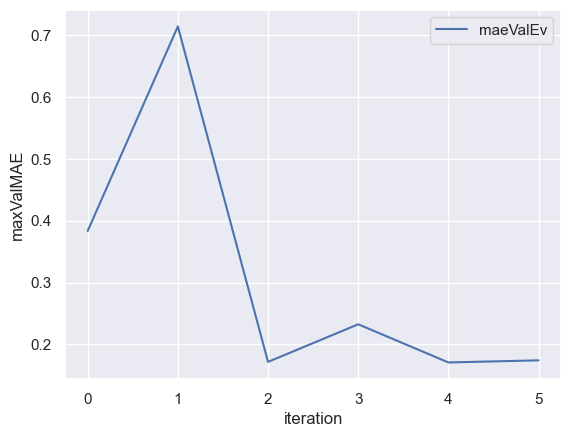

In [83]:
plt.plot(mae_valResults, label="maeValEv")
plt.xlabel("iteration")
plt.ylabel("maxValMAE")
plt.legend()
plt.show()

$\textit{The best model}$

In [8]:
INIT_LR = 0.0001
MAX_LR = 0.1
BATCH_SIZE = 256

steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

loc = './Model/MorphometricMNIST_E/training_history.log'
callbackH = helper.callbackH(location=loc)

callbackROP = ReduceLROnPlateau(monitor="val_mae",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 10,
                      max_lr = MAX_LR)

callbackES = EarlyStopping(monitor="val_mae", patience=20)
initializer = GlorotNormal(1)

entImg = Input(shape=(28,28))

lbl = Input(shape=(1,))
emb = Embedding(len(labels), 2, input_length=1, name="Embe")(lbl)

faltEmb = Flatten()(emb)
flatImg = Flatten()(entImg)

concat = Concatenate()([flatImg, faltEmb])

model = Sequential()
model.add(Dense(100, activation="elu", kernel_initializer=initializer))
model.add(Dense(100, activation="elu", kernel_initializer=initializer))
model.add(Dense(1, activation="linear", kernel_initializer=initializer))
net = model(concat)
model = Model(inputs=[entImg, lbl], outputs=net)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 Embe (Embedding)               (None, 1, 2)         20          ['input_4[0][0]']                
                                                                                                  
 flatten_3 (Flatten)            (None, 784)          0           ['input_3[0][0]']                
                                                                                            

In [10]:
model.compile(loss = MeanAbsoluteError(), optimizer=Adam(), metrics=["mae"])
history = model.fit(x=[x_train, x_emb], y =y_train, validation_data=([x_val, x_emb_val], y_val), callbacks=[callbackES, callbackROP, callbackH], batch_size = BATCH_SIZE, epochs=1000)
model.save("./Model/MorphometricMNIST_E")

Epoch 1/1000
196/196 [==============================] - 1s 4ms/step - loss: 0.5573 - mae: 0.5573 - val_loss: 0.3603 - val_mae: 0.3603 - lr: 0.0010
Epoch 2/1000
196/196 [==============================] - 1s 3ms/step - loss: 0.3141 - mae: 0.3141 - val_loss: 0.2708 - val_mae: 0.2708 - lr: 0.0010
Epoch 3/1000
196/196 [==============================] - 1s 3ms/step - loss: 0.2573 - mae: 0.2573 - val_loss: 0.2428 - val_mae: 0.2428 - lr: 0.0010
Epoch 4/1000
196/196 [==============================] - 1s 3ms/step - loss: 0.2225 - mae: 0.2225 - val_loss: 0.2089 - val_mae: 0.2089 - lr: 0.0010
Epoch 5/1000
196/196 [==============================] - 1s 3ms/step - loss: 0.2003 - mae: 0.2003 - val_loss: 0.1926 - val_mae: 0.1926 - lr: 0.0010
Epoch 6/1000
196/196 [==============================] - 1s 4ms/step - loss: 0.1878 - mae: 0.1878 - val_loss: 0.1905 - val_mae: 0.1905 - lr: 0.0010
Epoch 7/1000
196/196 [==============================] - 1s 3ms/step - loss: 0.1802 - mae: 0.1802 - val_loss: 0.2050 - 

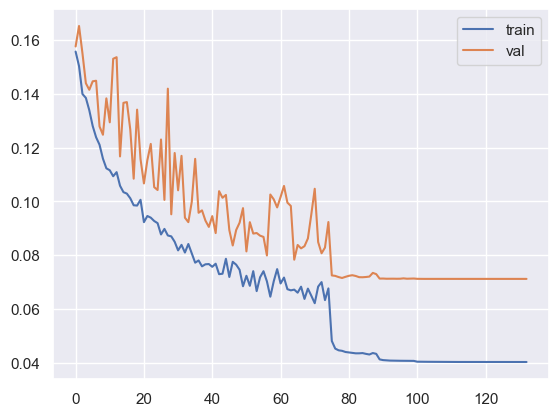

In [11]:
plt.plot(history.history["mae"][10:], label="train")
plt.plot(history.history["val_mae"][10:], label="val")
plt.legend()
plt.show()

In [12]:
model = load_model("./Model/MorphometricMNIST_E", compile=False)
predicted = model.predict([x_test, y_test]).reshape(10000,)
df = pd.DataFrame()
df["pred"] = predicted
df["target"] = test_morpho.slant
m = (np.abs(df.pred-df.target)).sum()/len(df.pred)
print(f"MAE_TEST: {m}")
df

313/313 [==============================] - 1s 1ms/step
MAE_TEST: 0.07090015582607583


,pred,target
0,4.121837,4.066199
1,-9.812191,-9.962917
2,16.595333,16.638250
3,4.204470,4.146705
4,-7.258540,-7.378214
...,...,...
9995,-1.453247,-1.446727
9996,-4.277240,-4.309251
9997,11.241741,11.246739
9998,30.429192,30.389567
